In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large, MobileNetV2
from keras.applications.mobilenet_v3 import preprocess_input
from keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow_addons as tfa
from tensorflow.keras import mixed_precision

# 데이터셋 로더

In [9]:
# **1. GPU 메모리 성장 설정 (가장 먼저 실행)**
physical_devices = tf.config.list_physical_devices('GPU')
for gpu in physical_devices:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
        print(f"메모리 성장 설정 완료: {gpu}")
    except RuntimeError as e:
        print(f"메모리 성장 설정 실패: {gpu} - {e}")

# **2. 분산 전략 설정**
# 분산 전략 설정: GPU 수에 따라 설정
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) >= 1:
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])  # GPU 디바이스 번호에 맞게 수정
    print(f'사용 중인 디바이스 수: {strategy.num_replicas_in_sync}')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'기본 전략 사용 중: {strategy.num_replicas_in_sync}')

# **4. 데이터셋 로더 함수**
def load_data(csv_file, image_dir):
    df = pd.read_csv(csv_file)
    image_paths = df['image_path'].tolist()
    keypoints = df.iloc[:, 1:].values.astype(np.float32)  # [x1, y1, x2, y2, ..., x70, y70]
    return image_paths, keypoints

# **5. 데이터 증강 함수 정의 (회전 및 줌인/아웃)**
def augment(image, keypoints, target_size=224):
    NUM_KEYPOINTS = 70  # 70개의 키포인트

    # 랜덤 회전 (-15도 ~ 15도)
    angle = tf.random.uniform([], -15, 15, dtype=tf.float32)
    angle_rad = angle * np.pi / 180.0
    image = tfa.image.rotate(image, angles=angle_rad, fill_mode='nearest')

    # 키포인트 회전
    center = tf.constant([target_size / 2.0, target_size / 2.0], dtype=tf.float32)
    keypoints = tf.reshape(keypoints, [NUM_KEYPOINTS, 2])  # [70, 2]
    rotation_matrix = tf.reshape([
        tf.cos(angle_rad), -tf.sin(angle_rad),
        tf.sin(angle_rad), tf.cos(angle_rad)
    ], [2, 2])
    keypoints = tf.matmul(keypoints - center, rotation_matrix) + center

    # 랜덤 줌인/아웃
    zoom_factor = tf.random.uniform([], 0.9, 1.1, dtype=tf.float32)

    # 이미지 크기 변경
    new_size = tf.cast(target_size * zoom_factor, tf.int32)
    image = tf.image.resize(image, [new_size, new_size])

    # 중앙에서 크롭 또는 패딩
    image = tf.image.resize_with_crop_or_pad(image, target_size, target_size)

    # 줌에 따른 키포인트 조정
    padding = tf.cast(target_size - new_size, tf.float32) / 2.0
    keypoints = keypoints * zoom_factor + padding

    # 키포인트 재정렬
    keypoints = tf.reshape(keypoints, [-1])  # [x1, y1, x2, y2, ..., x70, y70]

    # 키포인트 정규화
    keypoints_normalized = keypoints / tf.cast(target_size, tf.float32)

    # 키포인트가 [0,1] 범위 내에 있는지 확인
    condition_x = tf.reduce_all(tf.logical_and(keypoints_normalized[::2] >= 0.0, keypoints_normalized[::2] <= 1.0))
    condition_y = tf.reduce_all(tf.logical_and(keypoints_normalized[1::2] >= 0.0, keypoints_normalized[1::2] <= 1.0))
    is_valid = tf.logical_and(condition_x, condition_y)

    return image, keypoints_normalized, is_valid

# **6. 이미지 및 키포인트 전처리 함수 (종횡비 유지 및 패딩 추가)**
def preprocess_image(image_path, keypoints, image_dir, target_size=224, original_width=720, original_height=1280):
    # 이미지 경로 결합
    image_full_path = tf.strings.join([image_dir, '/', image_path])

    # 이미지 로드 및 디코드
    image = tf.io.read_file(image_full_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # 이미지가 정상적으로 로드되었는지 확인하고, float32로 변환 및 [0,1] 범위로 스케일링
    image = tf.cond(tf.equal(tf.size(image), 0),
                   lambda: tf.zeros([target_size, target_size, 3], dtype=tf.float32),
                   lambda: tf.image.convert_image_dtype(image, tf.float32))

    # 원본 크기 가져오기
    orig_shape = tf.shape(image)[:2]
    orig_height_img = tf.cast(orig_shape[0], tf.float32)
    orig_width_img = tf.cast(orig_shape[1], tf.float32)

    # 종횡비 유지하며 리사이징
    scale = tf.minimum(target_size / orig_width_img, target_size / orig_height_img)
    new_width = tf.cast(tf.round(orig_width_img * scale), tf.int32)
    new_height = tf.cast(tf.round(orig_height_img * scale), tf.int32)

    image = tf.image.resize(image, [new_height, new_width])

    # 패딩 추가하여 타겟 사이즈 맞추기
    pad_width = target_size - new_width
    pad_height = target_size - new_height
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top

    image = tf.pad(image, [[pad_top, pad_bottom], [pad_left, pad_right], [0, 0]], constant_values=0)

    # 키포인트 스케일 조정 및 이동 (Pixel space, not normalized)
    keypoints = tf.convert_to_tensor(keypoints, dtype=tf.float32)
    x_coords = keypoints[0:140:2]  # x1~x70
    y_coords = keypoints[1:140:2]  # y1~y70

    # 스케일링 및 이동
    x_scale = scale
    y_scale = scale

    x_scaled = x_coords * x_scale + tf.cast(pad_left, tf.float32)
    y_scaled = y_coords * y_scale + tf.cast(pad_top, tf.float32)

    scaled_keypoints = tf.stack([x_scaled, y_scaled], axis=1)  # [70, 2]
    scaled_keypoints = tf.reshape(scaled_keypoints, [-1])  # [x1, y1, x2, y2, ..., x70, y70]

    return image, scaled_keypoints  # 정규화된 키포인트가 아닌 픽셀 좌표 반환

# **7. 키포인트 정규화 함수**
def normalize_keypoints(image, keypoints, target_size=224):
    keypoints_normalized = keypoints / tf.cast(target_size, tf.float32)
    return image, keypoints_normalized

# **8. 데이터셋 전처리 및 증강 함수**
def preprocess_image_aug(image_path, keypoints, image_dir, target_size=224, original_width=720, original_height=1280):
    image, keypoints = preprocess_image(image_path, keypoints, image_dir, target_size, original_width, original_height)
    image_original, keypoints_original = image, keypoints  # 원본 이미지와 키포인트 저장

    # 증강 시도
    image_aug, keypoints_aug, is_valid = augment(image, keypoints, target_size)

    # 증강 성공 시 증강된 이미지과 키포인트, 실패 시 원본 이미지와 키포인트 반환
    image_final = tf.cond(is_valid, lambda: image_aug, lambda: image_original)
    keypoints_final = tf.cond(is_valid, lambda: keypoints_aug, lambda: keypoints_original)  # 이미 정규화됨

    return image_final, keypoints_final, is_valid  # 추가 정규화 제거

# **9. 데이터셋 생성 함수 수정**
def create_dataset(image_paths, keypoints, image_dir, batch_size=64, shuffle=True, augment_data=False, target_size=224, original_width=720, original_height=1280):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, keypoints))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))

    # image_dir을 TensorFlow 상수로 변환
    image_dir_tf = tf.constant(image_dir)

    if augment_data:
        # 데이터 증강 적용
        dataset = dataset.map(
            lambda x, y: preprocess_image_aug(x, y, image_dir_tf, target_size, original_width, original_height),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        # Augment 함수에서 반환하는 is_valid 유지
        # is_valid가 True인 경우만 포함
        dataset = dataset.filter(lambda image, keypoints, is_valid: is_valid)
        # (image, keypoints, is_valid) -> (image, keypoints)
        dataset = dataset.map(lambda image, keypoints, is_valid: (image, keypoints))
    else:
        # 데이터 증강 미적용
        dataset = dataset.map(
            lambda x, y: preprocess_image(x, y, image_dir_tf, target_size, original_width, original_height),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        # **변경 사항**: 키포인트 정규화 추가
        dataset = dataset.map(
            lambda image, keypoints: normalize_keypoints(image, keypoints, target_size),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# **10. 데이터셋 합치기 함수**
def combine_datasets(original_dataset, augmented_dataset):
    combined_dataset = original_dataset.concatenate(augmented_dataset)
    return combined_dataset

메모리 성장 설정 완료: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
메모리 성장 설정 완료: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
메모리 성장 설정 완료: PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
사용 중인 디바이스 수: 1


In [10]:
# **CSV 파일 경로**
train_csv = 'keras_dataset/annotations/train_annotations.csv'
val_csv = 'keras_dataset/annotations/val_annotations.csv'

# **이미지 디렉토리**
train_image_dir = 'keras_dataset/images/train'
val_image_dir = 'keras_dataset/images/val'

# **로드된 데이터**
train_image_paths, train_keypoints = load_data(train_csv, train_image_dir)
val_image_paths, val_keypoints = load_data(val_csv, val_image_dir)

# **훈련 데이터 절반으로 분할**
num_train = len(train_image_paths)
half_num_train = num_train // 2

original_train_image_paths = train_image_paths[:half_num_train]
original_train_keypoints = train_keypoints[:half_num_train]

aug_train_image_paths = train_image_paths[half_num_train:]
aug_train_keypoints = train_keypoints[half_num_train:]

print(f"원본 훈련 데이터 수: {len(original_train_image_paths)}")
print(f"증강할 훈련 데이터 수: {len(aug_train_image_paths)}")

# **전체 배치 크기 설정**
BATCH_SIZE_PER_REPLICA = 16  # 각 GPU당 배치 크기 (메모리 문제를 방지하기 위해 줄임)
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync  # 전체 배치 크기

# **훈련 데이터셋 생성**
with strategy.scope():
    # 원본 데이터셋 (절반)
    original_train_dataset = create_dataset(
        original_train_image_paths,
        original_train_keypoints,
        train_image_dir,
        batch_size=GLOBAL_BATCH_SIZE,
        shuffle=True,
        augment_data=False,  # 원본 데이터는 증강 미적용
        target_size=224,
        original_width=720,
        original_height=1280
    )

    # 증강 데이터셋 (절반)
    augmented_train_dataset = create_dataset(
        aug_train_image_paths,
        aug_train_keypoints,
        train_image_dir,
        batch_size=GLOBAL_BATCH_SIZE,
        shuffle=True,
        augment_data=True,  # 증강 데이터는 증강 적용
        target_size=224,
        original_width=720,
        original_height=1280
    )

    # **디버깅용: 증강 성공 및 실패 개수 계산**
    def count_augmentation_success(dataset):
        success = 0
        total = 0
        for batch in dataset.unbatch().as_numpy_iterator():
            image, keypoints = batch
            # 이 시점에서는 is_valid가 True인 데이터만 포함되므로 전체는 success
            success += 1
            total += 1
        return success, total

    # 증강 데이터셋에서 is_valid=True인 데이터 수
    augmented_success, augmented_total = count_augmentation_success(augmented_train_dataset)
    print(f"증강 성공한 이미지 수: {augmented_success}")
    print(f"증강 시도한 전체 이미지 수: {len(aug_train_image_paths)}")
    print(f"증강 실패한 이미지 수: {len(aug_train_image_paths) - augmented_success}")

    # 두 데이터셋 병합
    train_dataset = combine_datasets(original_train_dataset, augmented_train_dataset)

# **검증 데이터셋 생성**
with strategy.scope():
    # 원본 검증 데이터셋
    original_val_dataset = create_dataset(
        val_image_paths,
        val_keypoints,
        val_image_dir,
        batch_size=GLOBAL_BATCH_SIZE,
        shuffle=False,
        augment_data=False,  # 검증 데이터는 증강 미적용
        target_size=224,
        original_width=720,
        original_height=1280
    )

    # 두 검증 데이터셋 병합
    val_dataset = original_val_dataset

원본 훈련 데이터 수: 20526
증강할 훈련 데이터 수: 20526
증강 성공한 이미지 수: 20523
증강 시도한 전체 이미지 수: 20526
증강 실패한 이미지 수: 3


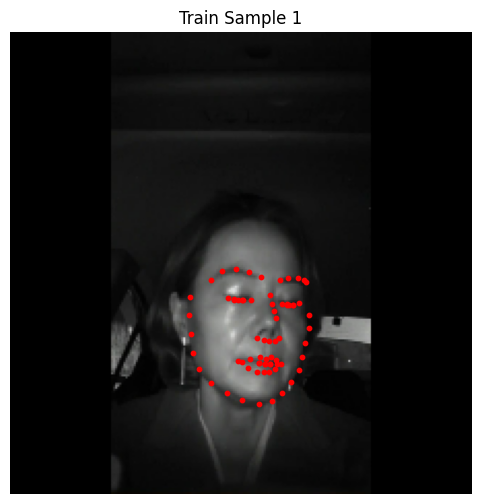

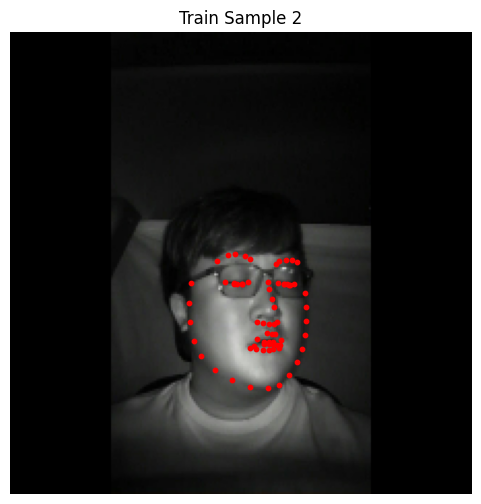

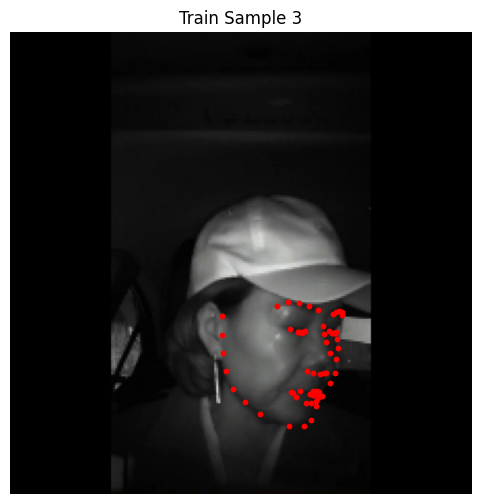

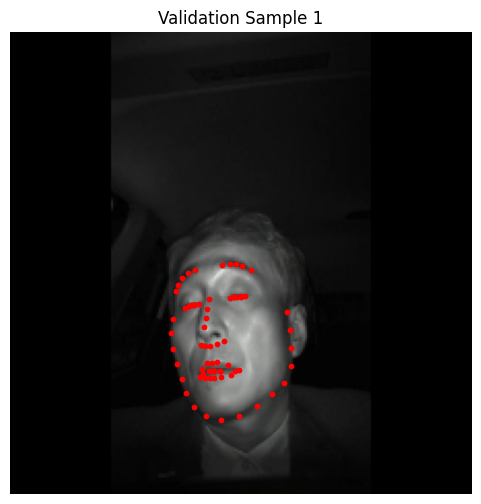

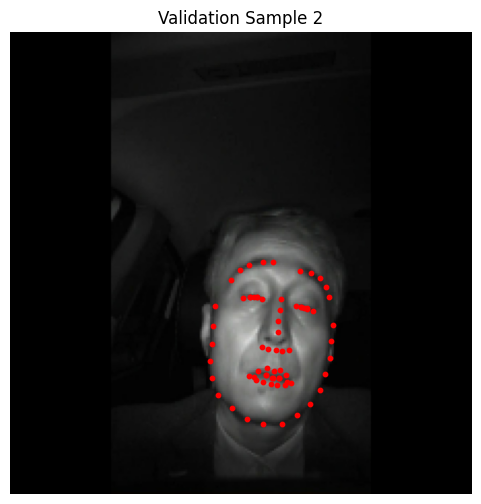

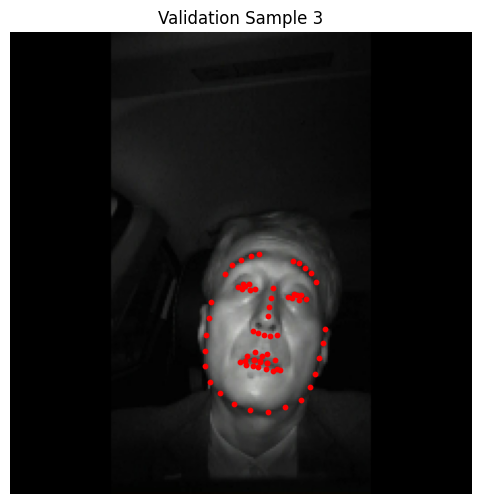


훈련 데이터셋 전체 이미지 수: 41043
검증 데이터셋 전체 이미지 수: 5447


In [11]:
# **데이터셋 일부 시각화 (디버깅 용도)**
def visualize_sample(image, keypoints, title='Sample', image_size=224):
    image_np = image.numpy()
    plt.figure(figsize=(6, 6))
    plt.imshow(image_np)
    # 키포인트를 224x224 이미지에 맞게 스케일링
    x = keypoints[::2].numpy() * image_size  # [0,1] 범위를 [0,224]로 변환
    y = keypoints[1::2].numpy() * image_size
    plt.scatter(x, y, c='r', s=10)
    plt.title(title)
    plt.axis('off')
    plt.show()

# **훈련 데이터셋 샘플 시각화**
for batch in train_dataset.take(1):
    images, keypoints = batch
    for i in range(3):  # 첫 3개 샘플 시각화
        visualize_sample(images[i], keypoints[i], title=f"Train Sample {i+1}")

# **검증 데이터셋 샘플 시각화**
for batch in val_dataset.take(1):
    images, keypoints = batch
    for i in range(3):  # 첫 3개 샘플 시각화
        visualize_sample(images[i], keypoints[i], title=f"Validation Sample {i+1}")

# **전체 데이터셋 크기 확인**
def count_total_images(dataset):
    total = 0
    for batch in dataset:
        images, keypoints = batch
        total += images.shape[0]
    return total

train_total = count_total_images(train_dataset)
val_total = count_total_images(val_dataset)

print(f"\n훈련 데이터셋 전체 이미지 수: {train_total}")
print(f"검증 데이터셋 전체 이미지 수: {val_total}")

# 모델학습

In [12]:
import keras
from keras import layers

# 1. 키포인트 수
NUM_KEYPOINTS = 70

with strategy.scope():
    # 입력 레이어 정의
    inputs = layers.Input(shape=(224, 224, 3))
    x = preprocess_input(inputs)

    # 백본 모델 로드 (pre-trained MobileNetV3Large)
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = True  # 백본 모델을 학습하도록 설정

    x = base_model(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    # 출력 레이어: 70개의 키포인트, 각 키포인트에 대해 x, y 좌표 (총 140개 출력)
    # 타겟 값이 [0, 1] 범위로 정규화되었다면 sigmoid 활성화 함수 사용
    x = layers.Dense(NUM_KEYPOINTS * 2, activation='sigmoid', dtype='float32')(x)

    # 모델 정의
    model = keras.Model(inputs=inputs, outputs=x)

    # 모델 컴파일
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# 모델 요약 출력
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 1280)        5120      
 chNormalization)                                          

In [13]:
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, CSVLogger
        
# 콜백 설정
checkpoint = ModelCheckpoint('v2_adam_lr001_half_aug.h5', monitor='val_loss', save_best_only=True, verbose=1)
csv_logger = CSVLogger('v2_adam_lr001_half_aug.csv', append=True)

# **모델 훈련**

EPOCHS = 100

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, csv_logger]
)

Epoch 1/100
   2566/Unknown - 219s 75ms/step - loss: 6.1686e-04 - mae: 0.0176

2024-11-17 14:28:35.133203: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 3022233567142676641
2024-11-17 14:28:35.133288: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12078099605371413541
2024-11-17 14:28:35.133296: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 261466472821245793
2024-11-17 14:28:35.133308: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11290030620250388770
2024-11-17 14:28:35.133313: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 8022687667591285371
2024-11-17 14:28:35.133324: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13334434764755199487
2024-11-17 14:28:35.133334: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv i


Epoch 1: val_loss improved from inf to 0.03811, saving model to v2_adam_lr001_half_aug.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2566/2566 [==============================] - 230s 79ms/step - loss: 6.1686e-04 - mae: 0.0176 - val_loss: 0.0381 - val_mae: 0.1737
Epoch 2/100
2566/2566 [==============================] - ETA: 0s - loss: 3.6342e-04 - mae: 0.0151
Epoch 2: val_loss improved from 0.03811 to 0.02966, saving model to v2_adam_lr001_half_aug.h5
2566/2566 [==============================] - 204s 80ms/step - loss: 3.6342e-04 - mae: 0.0151 - val_loss: 0.0297 - val_mae: 0.1493
Epoch 3/100
2565/2566 [============================>.] - ETA: 0s - loss: 3.6260e-04 - mae: 0.0150
Epoch 3: val_loss improved from 0.02966 to 0.01089, saving model to v2_adam_lr001_half_aug.h5
2566/2566 [==============================] - 203s 79ms/step - loss: 3.6260e-04 - mae: 0.0150 - val_loss: 0.0109 - val_mae: 0.0887
Epoch 4/100
2566/2566 [==============================] - ETA: 0s - loss: 3.5035e-04 - mae: 0.0148
Epoch 4: val_loss improved from 0.01089 to 0.00846, saving model to v2_adam_lr001_half_aug.h5
2566/2566 [=======================

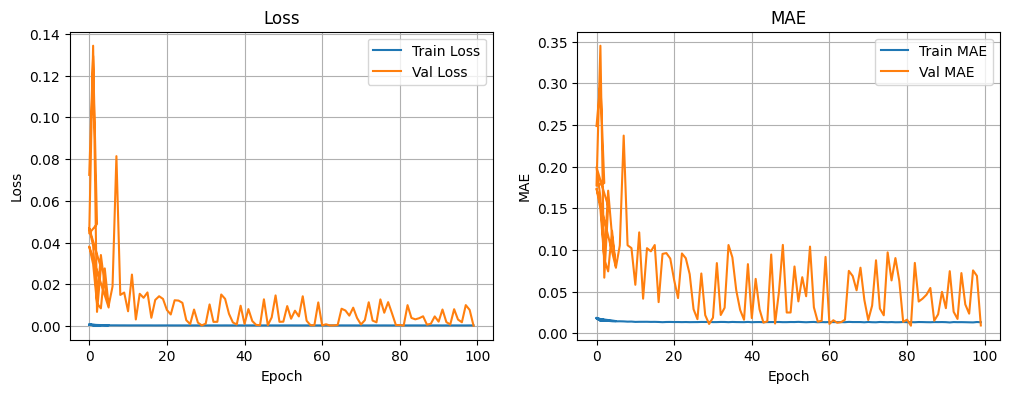

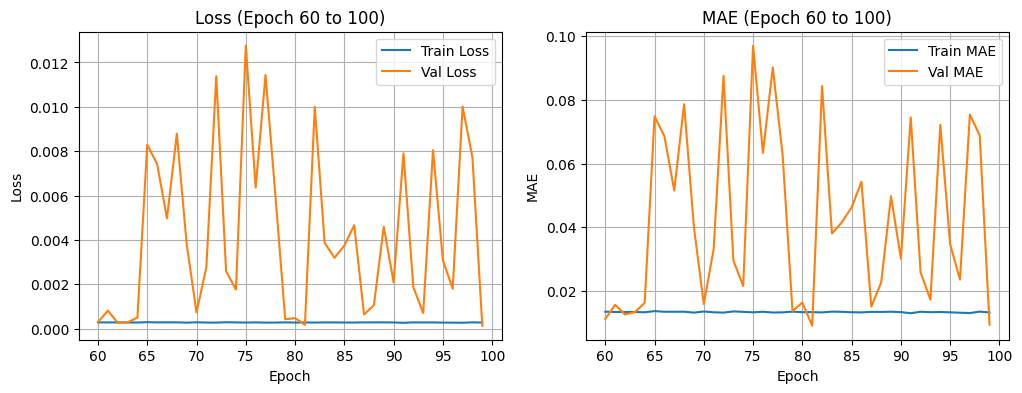

Best Epoch: 100
Minimum Validation Loss: 0.0001359552261419


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 경로 설정
csv_file_path = 'csv_logger/v2_adam_lr001_half_aug.csv'

# CSV 파일 읽기
history_df = pd.read_csv(csv_file_path)

# 에포크 수 가져오기
epochs = history_df['epoch']

# 전체 에포크 그래프 그리기
plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, history_df['loss'], label='Train Loss')
plt.plot(epochs, history_df['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, history_df['mae'], label='Train MAE')
plt.plot(epochs, history_df['val_mae'], label='Val MAE')
plt.legend()
plt.title('MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)

plt.show()

# 특정 에포크 범위 설정
start_epoch = 60  # 시작 에포크 (0부터 시작)
end_epoch = 100   # 끝 에포크 (포함하지 않음)

# 에포크 범위에 해당하는 인덱스 생성
epoch_range = (history_df['epoch'] >= start_epoch) & (history_df['epoch'] < end_epoch)

# 선택한 에포크 범위의 데이터 선택
selected_epochs = history_df['epoch'][epoch_range]
train_loss = history_df['loss'][epoch_range]
val_loss = history_df['val_loss'][epoch_range]
train_mae = history_df['mae'][epoch_range]
val_mae = history_df['val_mae'][epoch_range]

# 선택한 에포크 범위 그래프 그리기
plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(selected_epochs, train_loss, label='Train Loss')
plt.plot(selected_epochs, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss (Epoch {} to {})'.format(start_epoch, end_epoch))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(selected_epochs, train_mae, label='Train MAE')
plt.plot(selected_epochs, val_mae, label='Val MAE')
plt.legend()
plt.title('MAE (Epoch {} to {})'.format(start_epoch, end_epoch))
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)

plt.show()

min_val_loss = history_df['val_loss'].min()
best_epoch = history_df[history_df['val_loss'] == min_val_loss]['epoch'].values[0] + 1  # 1을 더해줍니다.
print(f"Best Epoch: {best_epoch}")
print(f"Minimum Validation Loss: {min_val_loss}")

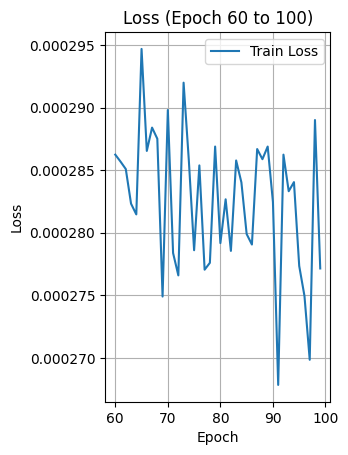

In [22]:
# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(selected_epochs, train_loss, label='Train Loss')
plt.legend()
plt.title('Loss (Epoch {} to {})'.format(start_epoch, end_epoch))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

In [24]:
# **저장할 디렉토리 경로 설정**
train_save_path = 'saved_datasets/train_dataset'
val_save_path = 'saved_datasets/val_dataset'

# **데이터셋 저장**
tf.data.experimental.save(train_dataset, train_save_path)
tf.data.experimental.save(val_dataset, val_save_path)

print("훈련 데이터셋과 검증 데이터셋이 성공적으로 저장되었습니다.")

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.
훈련 데이터셋과 검증 데이터셋이 성공적으로 저장되었습니다.


In [25]:
# **저장된 데이터셋 로드**
train_loaded = tf.data.experimental.load(train_save_path, element_spec=train_dataset.element_spec)
val_loaded = tf.data.experimental.load(val_save_path, element_spec=val_dataset.element_spec)

print("훈련 데이터셋과 검증 데이터셋이 성공적으로 로드되었습니다.")

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.
훈련 데이터셋과 검증 데이터셋이 성공적으로 로드되었습니다.


In [26]:
# 분산 전략 설정: GPU 수에 따라 설정
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) >= 1:
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1", "/gpu:2"])
    print(f'사용 중인 디바이스 수: {strategy.num_replicas_in_sync}')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'기본 전략 사용 중: {strategy.num_replicas_in_sync}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
사용 중인 디바이스 수: 3


In [28]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, CSVLogger
import time
from tensorflow.keras import layers, models

# 분산 전략 내에서 모델 정의 및 컴파일
with strategy.scope():
    # 3. 모델 로드
    model = tf.keras.models.load_model('model_h5/v2_adam_lr001_half_aug.h5')
    
    # 4. 모델 컴파일
    # 옵티마이저, 손실 함수, 평가 지표를 정의합니다.
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
        loss='mse',
        metrics=['mae']
    )
    
    # 5. 콜백 설정
    checkpoint = ModelCheckpoint('v2_rmsprop_half_aug.h5', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=1)
    csv_logger = CSVLogger('v2_rmsprop_half_aug.csv', append=True)
    
    # 6. 배치 사이즈 설정
    per_replica_batch_size = 16
    GLOBAL_BATCH_SIZE = per_replica_batch_size * strategy.num_replicas_in_sync
    
    # 7. 모델 훈련
    EPOCHS = 50
    
    history = model.fit(
        train_loaded,
        epochs=EPOCHS,
        validation_data=val_loaded,
        callbacks=[checkpoint, reduce_lr, csv_logger]
    )

Epoch 1/50
INFO:tensorflow:Collective all_reduce tensors: 160 all_reduces, num_devices = 3, group_size = 3, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 160 all_reduces, num_devices = 3, group_size = 3, implementation = CommunicationImplementation.NCCL, num_packs = 1


2024-11-18 01:20:30.103768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-18 01:20:30.131523: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907


2566/2566 [==============================] - ETA: 0s - loss: 7.4284e-04 - mae: 0.0215
Epoch 1: val_loss improved from inf to 0.00004, saving model to v2_rmsprop_half_aug.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2566/2566 [==============================] - 228s 68ms/step - loss: 7.4284e-04 - mae: 0.0215 - val_loss: 4.4703e-05 - val_mae: 0.0049 - lr: 0.0010
Epoch 2/50
2565/2566 [============================>.] - ETA: 0s - loss: 7.4169e-04 - mae: 0.0215
Epoch 2: val_loss did not improve from 0.00004
2566/2566 [==============================] - 158s 62ms/step - loss: 7.4194e-04 - mae: 0.0215 - val_loss: 4.5299e-05 - val_mae: 0.0049 - lr: 0.0010
Epoch 3/50
2565/2566 [============================>.] - ETA: 0s - loss: 7.4049e-04 - mae: 0.0215
Epoch 3: val_loss did not improve from 0.00004
2566/2566 [==============================] - 153s 60ms/step - loss: 7.4076e-04 - mae: 0.0215 - val_loss: 4.8801e-05 - val_mae: 0.0052 - lr: 0.0010
Epoch 4/50
2565/2566 [============================>.] - ETA: 0s - loss: 7.4085e-04 - mae: 0.0215
Epoch 4: val_loss did not improve from 0.00004
2566/2566 [==============================] - 157s 61ms/step - loss: 7.4113e-04 - mae: 0.0215 - val_loss: 4.7970e-05 - val_mae: 

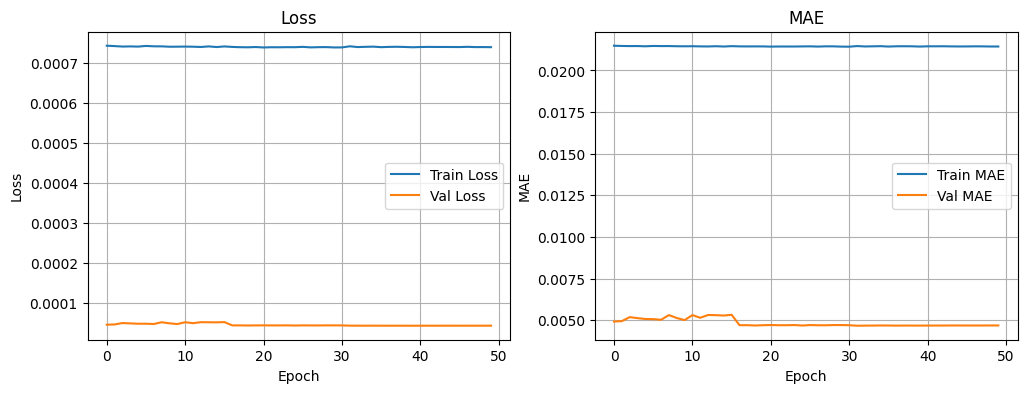

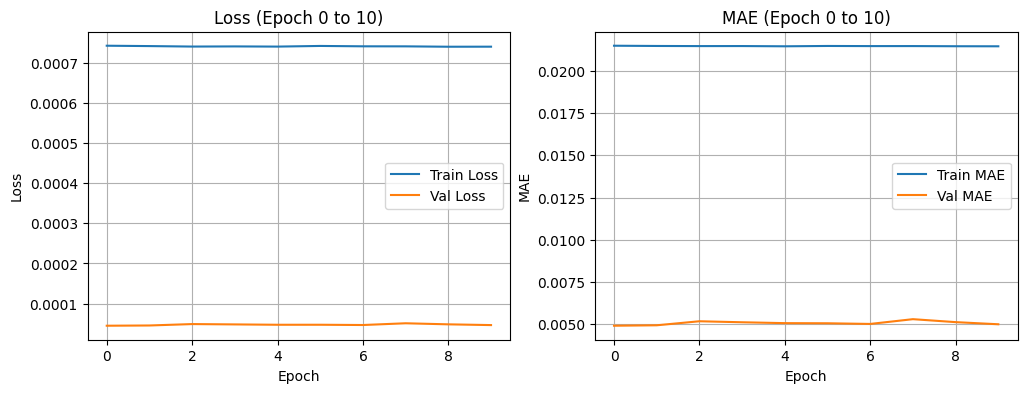

Best Epoch: 40
Minimum Validation Loss: 4.213884676573798e-05


In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 경로 설정
csv_file_path = 'csv_logger/v2_rmsprop_half_aug.csv'

# CSV 파일 읽기
history_df = pd.read_csv(csv_file_path)

# 에포크 수 가져오기
epochs = history_df['epoch']

# 전체 에포크 그래프 그리기
plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, history_df['loss'], label='Train Loss')
plt.plot(epochs, history_df['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, history_df['mae'], label='Train MAE')
plt.plot(epochs, history_df['val_mae'], label='Val MAE')
plt.legend()
plt.title('MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)

plt.show()

# 특정 에포크 범위 설정
start_epoch = 0  # 시작 에포크 (0부터 시작)
end_epoch = 10   # 끝 에포크 (포함하지 않음)

# 에포크 범위에 해당하는 인덱스 생성
epoch_range = (history_df['epoch'] >= start_epoch) & (history_df['epoch'] < end_epoch)

# 선택한 에포크 범위의 데이터 선택
selected_epochs = history_df['epoch'][epoch_range]
train_loss = history_df['loss'][epoch_range]
val_loss = history_df['val_loss'][epoch_range]
train_mae = history_df['mae'][epoch_range]
val_mae = history_df['val_mae'][epoch_range]

# 선택한 에포크 범위 그래프 그리기
plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(selected_epochs, train_loss, label='Train Loss')
plt.plot(selected_epochs, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss (Epoch {} to {})'.format(start_epoch, end_epoch))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(selected_epochs, train_mae, label='Train MAE')
plt.plot(selected_epochs, val_mae, label='Val MAE')
plt.legend()
plt.title('MAE (Epoch {} to {})'.format(start_epoch, end_epoch))
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)

plt.show()

min_val_loss = history_df['val_loss'].min()
best_epoch = history_df[history_df['val_loss'] == min_val_loss]['epoch'].values[0] + 1  # 1을 더해줍니다.
print(f"Best Epoch: {best_epoch}")
print(f"Minimum Validation Loss: {min_val_loss}")